# Setup

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Read data

In [2]:
df = pd.read_csv("metastatic_local_o1.csv")


# Preprocessing

## Ground truth

In [3]:
# Create ground_truth_metastatic and ground_truth_local columns from accept column
df["ground_truth_metastatic"] = df["accept"].str.contains("METASTATIC")
df["ground_truth_local"] = df["accept"].str.contains("LOCAL")


## GPT 4o

In [4]:
# Create gpt4o_metastatic and gpt4o_local columns from gpt4o_temp100_response_raw column
df[["gpt4o_metastatic", "gpt4o_local"]] = df["gpt4o_temp100_response_raw"].str.extract(r"\[(True|False), (True|False)\]")
# Convert strings to boolean values
df[["gpt4o_metastatic", "gpt4o_local"]] = df[["gpt4o_metastatic", "gpt4o_local"]].apply(lambda x: x.map({"True": True, "False": False}))


## o1

In [5]:
# Identify cells with verbose output
df["o1_verbose"] = df["o1_temp100_response_raw"].str.len() > 14

# Count the number of verbose outputs
verbose_count = df["o1_verbose"].sum()

# Calculate the percentage of verbose outputs
verbose_percentage = 100 * verbose_count / df.shape[0]
print(f"Number of verbose outputs: {verbose_count} ({verbose_percentage:.1f}%)")


Number of verbose outputs: 84 (14.0%)


In [6]:
# Use regular expressions to extract the boolean values. Create two columns from the extracted values
df[["o1_metastatic", "o1_local"]] = df["o1_temp100_response_raw"].str.extract(
    r"\[(True|False), (True|False)\]"
)

# Convert strings to boolean values
df[["o1_metastatic", "o1_local"]] = df[["o1_metastatic", "o1_local"]].apply(
    lambda x: x.map({"True": True, "False": False})
)

In [7]:
df.head()


,doi,date,title,abstract,accept,tumor_type,family,gpt4o_temp100_response_raw,o1_temp100_response_raw,ground_truth_metastatic,ground_truth_local,gpt4o_metastatic,gpt4o_local,o1_verbose,o1_metastatic,o1_local
0,10.1016/S0140-6736(09)61921-8,2/20/10,Interferon alfa-2a versus combination therapy ...,BACKGROUND: In metastatic renal cell carcinoma...,['METASTATIC'],"['Renal', 'General metastases']",Urogenital,"[True, False]","[True, False]",True,False,True,False,False,True,False
1,10.1200/JCO.22.00451,12/20/22,Partial Breast Irradiation Versus Whole Breast...,PURPOSE: On the basis of low risk of local rec...,['LOCAL'],['Breast'],Breast/Gynecological,"[False, True]","[False, True]",False,True,False,True,False,False,True
2,10.1001/jamaoncol.2016.4115,2/1/17,Ramucirumab as Second-Line Treatment in Patien...,IMPORTANCE: REACH is the first phase 3 trial t...,"['METASTATIC', 'LOCAL']",['Hepatocellular'],Gastrointestinal,"[True, True]","[True, True]",True,True,True,True,False,True,True
3,10.1200/JCO.2006.07.0847,2/20/07,Sequenced compared with simultaneous anthracyc...,PURPOSE: We conducted a phase III randomized s...,['LOCAL'],['Breast'],Breast/Gynecological,"[False, True]","[False, True]",False,True,False,True,False,False,True
4,10.1200/JCO.21.02511,9/20/22,Randomized Phase II Study of Nivolumab With or...,PURPOSE: To evaluate the clinical benefit of n...,['METASTATIC'],"['Pancreas', 'General metastases']",Gastrointestinal,"[True, False]","[True, False]",True,False,True,False,False,True,False


# Analysis

## Dataset characteristics

In [8]:
# Create a crosstab of the ground truth local and metastatic columns
cross_tab = pd.crosstab(df["ground_truth_local"], df["ground_truth_metastatic"])

# Calculate percentages of respective fields in the data set
metastatic_and_local = 100 * cross_tab.loc[True, True] / df.shape[0]
metastatic_not_local = 100 * cross_tab.loc[False, True] / df.shape[0]
local_not_metastatic = 100 * cross_tab.loc[True, False] / df.shape[0]
neither = 100 * cross_tab.loc[False, False] / df.shape[0]
local = 100 * (metastatic_and_local + local_not_metastatic) / 100
metastatic = 100 * (metastatic_and_local + metastatic_not_local) / 100

print(
    f"Percentage of trials that allow both metastatic and localized disease: {metastatic_and_local:.1f}%"
)
print(
    f"Percentage of trials that allow metastatic disease but not localized disease: {metastatic_not_local:.1f}%"
)
print(
    f"Percentage of trials that allow localized disease but not metastatic disease: {local_not_metastatic:.1f}%"
)
print(
    f"Percentage of trials that allow neither metastatic nor localized disease: {neither:.1f}%"
)
print(f"Percentage of trials that allow localized disease: {local:.1f}%")
print(f"Percentage of trials that allow metastatic disease: {metastatic:.1f}%")

Percentage of trials that allow both metastatic and localized disease: 37.8%
Percentage of trials that allow metastatic disease but not localized disease: 21.3%
Percentage of trials that allow localized disease but not metastatic disease: 35.8%
Percentage of trials that allow neither metastatic nor localized disease: 5.0%
Percentage of trials that allow localized disease: 73.7%
Percentage of trials that allow metastatic disease: 59.2%


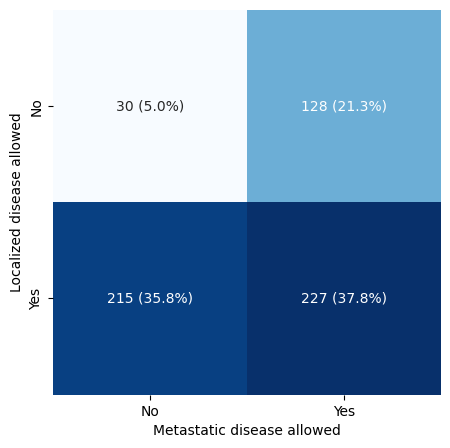

In [9]:
# Visualize the distribution of local and metastatic in the data set
fig = plt.figure(figsize=(5, 5))

# Create annotation labels with counts and percentages
labels = cross_tab.values.astype(str)
labels[0,0] = f"{cross_tab.values[0,0]} ({neither:.1f}%)"
labels[0,1] = f"{cross_tab.values[0,1]} ({metastatic_not_local:.1f}%)" 
labels[1,0] = f"{cross_tab.values[1,0]} ({local_not_metastatic:.1f}%)"
labels[1,1] = f"{cross_tab.values[1,1]} ({metastatic_and_local:.1f}%)"

sns.heatmap(cross_tab, annot=labels, cmap="Blues", fmt="")
plt.xlabel("Metastatic disease allowed")
plt.ylabel("Localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/characteristics.png", dpi=300, bbox_inches="tight")

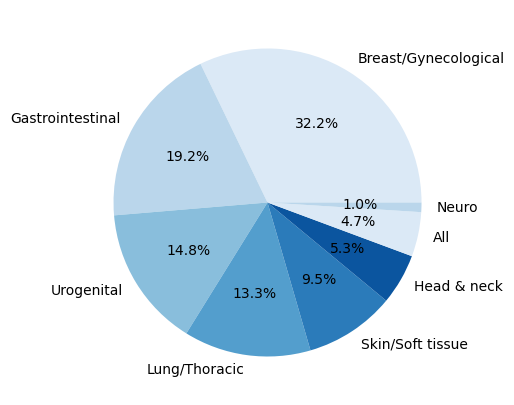

In [10]:
# Create a pie chart of the distribution of tumor family in the data set using seaborn
fig = plt.figure(figsize=(5, 5))
sns.set_palette("Blues")
df["family"].value_counts().plot.pie(autopct="%1.1f%%")
plt.ylabel("")
plt.show()

fig.savefig("plots/family_distribution.png", dpi=300, bbox_inches="tight")

## Analyze the performance of the models

## GPT-4o

In [11]:
# Create confusion matrix of predicted and actual values for LOCAL
cm_gpt4o_local = pd.crosstab(df["ground_truth_local"], df["gpt4o_local"])

# Calculate true positives, false positives, false negatives, and true negatives
tp_gpt4o_local = cm_gpt4o_local.loc[True, True]
fp_gpt4o_local = cm_gpt4o_local.loc[False, True]
fn_gpt4o_local = cm_gpt4o_local.loc[True, False]
tn_gpt4o_local = cm_gpt4o_local.loc[False, False]

# Calculate accuracy, precision, recall, f1 score
accuracy_gpt4o_local = (tp_gpt4o_local + tn_gpt4o_local) / (
    tp_gpt4o_local + tn_gpt4o_local + fp_gpt4o_local + fn_gpt4o_local
)
precision_gpt4o_local = tp_gpt4o_local / (tp_gpt4o_local + fp_gpt4o_local)
recall_gpt4o_local = tp_gpt4o_local / (tp_gpt4o_local + fn_gpt4o_local)
f1_score_gpt4o_local = (
    2
    * precision_gpt4o_local
    * recall_gpt4o_local
    / (precision_gpt4o_local + recall_gpt4o_local)
)

# Calucalate the 95% confidence interval for the accuracy, precision, recall, and f1 score
accuracy_gpt4o_local_ci = 1.96 * np.sqrt(
    (accuracy_gpt4o_local * (1 - accuracy_gpt4o_local)) / df.shape[0]
)
precision_gpt4o_local_ci = 1.96 * np.sqrt(
    (precision_gpt4o_local * (1 - precision_gpt4o_local)) / df.shape[0]
)
recall_gpt4o_local_ci = 1.96 * np.sqrt(
    (recall_gpt4o_local * (1 - recall_gpt4o_local)) / df.shape[0]
)
f1_score_gpt4o_local_ci = 1.96 * np.sqrt(
    (f1_score_gpt4o_local * (1 - f1_score_gpt4o_local)) / df.shape[0]
)

print(
    f"Accuracy: {accuracy_gpt4o_local:.2f} ({accuracy_gpt4o_local-accuracy_gpt4o_local_ci:.2f} - {accuracy_gpt4o_local+accuracy_gpt4o_local_ci:.2f})"
)
print(
    f"Precision: {precision_gpt4o_local:.2f} ({precision_gpt4o_local-precision_gpt4o_local_ci:.2f} - {precision_gpt4o_local+precision_gpt4o_local_ci:.2f})"
)
print(
    f"Recall: {recall_gpt4o_local:.2f} ({recall_gpt4o_local-recall_gpt4o_local_ci:.2f} - {recall_gpt4o_local+recall_gpt4o_local_ci:.2f})"
)
print(
    f"F1 score: {f1_score_gpt4o_local:.2f} ({f1_score_gpt4o_local-f1_score_gpt4o_local_ci:.2f} - {f1_score_gpt4o_local+f1_score_gpt4o_local_ci:.2f})"
)

Accuracy: 0.74 (0.71 - 0.78)
Precision: 0.96 (0.95 - 0.98)
Recall: 0.68 (0.64 - 0.71)
F1 score: 0.80 (0.76 - 0.83)


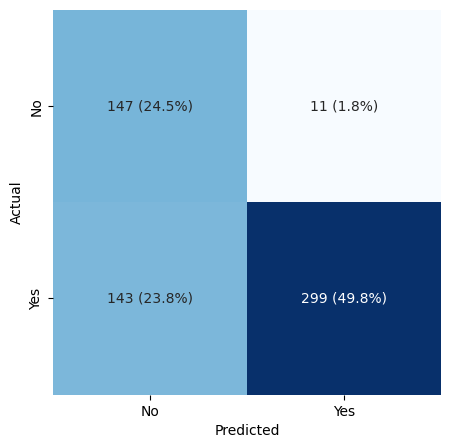

In [12]:
# Create confusion matrix of predicted and actual values for LOCAL
fig = plt.figure(figsize=(5, 5))

# Create labels with counts and percentages
labels_gpt4o_local = cm_gpt4o_local.values.astype(str)
labels_gpt4o_local[0, 0] = f"{cm_gpt4o_local.values[0,0]} ({100 * tn_gpt4o_local/df.shape[0]:.1f}%)"
labels_gpt4o_local[0, 1] = f"{cm_gpt4o_local.values[0,1]} ({100 * fp_gpt4o_local/df.shape[0]:.1f}%)"
labels_gpt4o_local[1, 0] = f"{cm_gpt4o_local.values[1,0]} ({100 * fn_gpt4o_local/df.shape[0]:.1f}%)"
labels_gpt4o_local[1, 1] = f"{cm_gpt4o_local.values[1,1]} ({100 * tp_gpt4o_local/df.shape[0]:.1f}%)"

sns.heatmap(cm_gpt4o_local, annot=labels_gpt4o_local, fmt="", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual") 
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/gpt4o_local_confusion.png", dpi=300, bbox_inches="tight")

In [13]:
# Create confusion matrix of predicted and actual values for METASTATIC
cm_gpt4o_metastatic = pd.crosstab(df["ground_truth_metastatic"], df["gpt4o_metastatic"])


# Calculate true positives, false positives, false negatives, and true negatives for METASTATIC
tp_gpt4o_metastatic = cm_gpt4o_metastatic.loc[True, True]
fp_gpt4o_metastatic = cm_gpt4o_metastatic.loc[False, True]
fn_gpt4o_metastatic = cm_gpt4o_metastatic.loc[True, False]
tn_gpt4o_metastatic = cm_gpt4o_metastatic.loc[False, False]

# Calculate accuracy, precision, recall, f1 score
accuracy_gpt4o_metastatic = (tp_gpt4o_metastatic + tn_gpt4o_metastatic) / (tp_gpt4o_metastatic + tn_gpt4o_metastatic + fp_gpt4o_metastatic + fn_gpt4o_metastatic)
precision_gpt4o_metastatic = tp_gpt4o_metastatic / (tp_gpt4o_metastatic + fp_gpt4o_metastatic)
recall_gpt4o_metastatic = tp_gpt4o_metastatic / (tp_gpt4o_metastatic + fn_gpt4o_metastatic)
f1_score_gpt4o_metastatic = 2 * precision_gpt4o_metastatic * recall_gpt4o_metastatic / (precision_gpt4o_metastatic + recall_gpt4o_metastatic)

# Calculate the 95% confidence interval for the accuracy, precision, recall, and f1 score
accuracy_gpt4o_metastatic_ci = 1.96 * np.sqrt((accuracy_gpt4o_metastatic * (1 - accuracy_gpt4o_metastatic)) / df.shape[0])
precision_gpt4o_metastatic_ci = 1.96 * np.sqrt((precision_gpt4o_metastatic * (1 - precision_gpt4o_metastatic)) / df.shape[0])
recall_gpt4o_metastatic_ci = 1.96 * np.sqrt((recall_gpt4o_metastatic * (1 - recall_gpt4o_metastatic)) / df.shape[0])
f1_score_gpt4o_metastatic_ci = 1.96 * np.sqrt((f1_score_gpt4o_metastatic * (1 - f1_score_gpt4o_metastatic)) / df.shape[0])

print(f"Accuracy: {accuracy_gpt4o_metastatic:.2f} ({accuracy_gpt4o_metastatic-accuracy_gpt4o_metastatic_ci:.2f} - {accuracy_gpt4o_metastatic+accuracy_gpt4o_metastatic_ci:.2f})")
print(f"Precision: {precision_gpt4o_metastatic:.2f} ({precision_gpt4o_metastatic-precision_gpt4o_metastatic_ci:.2f} - {precision_gpt4o_metastatic+precision_gpt4o_metastatic_ci:.2f})")
print(f"Recall: {recall_gpt4o_metastatic:.2f} ({recall_gpt4o_metastatic-recall_gpt4o_metastatic_ci:.2f} - {recall_gpt4o_metastatic+recall_gpt4o_metastatic_ci:.2f})")
print(f"F1 score: {f1_score_gpt4o_metastatic:.2f} ({f1_score_gpt4o_metastatic-f1_score_gpt4o_metastatic_ci:.2f} - {f1_score_gpt4o_metastatic+f1_score_gpt4o_metastatic_ci:.2f})")

Accuracy: 0.96 (0.95 - 0.98)
Precision: 0.98 (0.97 - 0.99)
Recall: 0.95 (0.94 - 0.97)
F1 score: 0.97 (0.95 - 0.98)


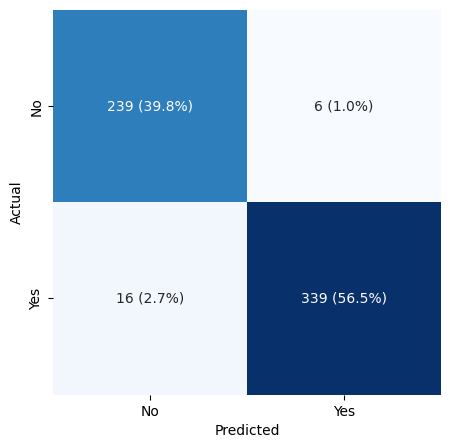

In [14]:
# Create confusion matrix of predicted and actual values for METASTATIC
fig = plt.figure(figsize=(5, 5))

# Create annotation labels with counts and percentages
labels_gpt4o_metastatic = cm_gpt4o_metastatic.values.astype(str)
labels_gpt4o_metastatic[0, 0] = (
    f"{cm_gpt4o_metastatic.values[0,0]} ({100 * tn_gpt4o_metastatic / df.shape[0]:.1f}%)"
)
labels_gpt4o_metastatic[0, 1] = (
    f"{cm_gpt4o_metastatic.values[0,1]} ({100 * fp_gpt4o_metastatic/df.shape[0]:.1f}%)"
)
labels_gpt4o_metastatic[1, 0] = (
    f"{cm_gpt4o_metastatic.values[1,0]} ({100 * fn_gpt4o_metastatic/df.shape[0]:.1f}%)"
)
labels_gpt4o_metastatic[1, 1] = (
    f"{cm_gpt4o_metastatic.values[1,1]} ({100 * tp_gpt4o_metastatic/df.shape[0]:.1f}%)"
)

sns.heatmap(cm_gpt4o_metastatic, annot=labels_gpt4o_metastatic, fmt="", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/gpt4o_metastatic_confusion.png", dpi=300, bbox_inches="tight")

In [15]:
# Calculate the F1 score for local per family

precision_gpt4o_local_per_family = df.groupby("family").apply(lambda x: np.sum((x["gpt4o_local"] == True) & (x["ground_truth_local"] == True))/ np.sum(x["gpt4o_local"] == True))
recall_gpt4o_local_per_family = df.groupby("family").apply(lambda x: np.sum((x["gpt4o_local"] == True) & (x["ground_truth_local"] == True))/ np.sum(x["ground_truth_local"] == True))
f1_score_gpt4o_local_per_family = 2 * precision_gpt4o_local_per_family * recall_gpt4o_local_per_family / (precision_gpt4o_local_per_family + recall_gpt4o_local_per_family)
f1_score_gpt4o_local_per_family = f1_score_gpt4o_local_per_family.round(2)

print(f1_score_gpt4o_local_per_family)


family
All                     0.86
Breast/Gynecological    0.84
Gastrointestinal        0.78
Head & neck             0.90
Lung/Thoracic           0.59
Neuro                   0.57
Skin/Soft tissue        0.71
Urogenital              0.89
dtype: float64


In [16]:
# Calculate the F1 score for metastatic per family
precision_gpt4o_metastatic_per_family = df.groupby("family").apply(lambda x: np.sum((x["gpt4o_metastatic"] == True) & (x["ground_truth_metastatic"] == True))/ np.sum(x["gpt4o_metastatic"] == True))
recall_gpt4o_metastatic_per_family = df.groupby("family").apply(lambda x: np.sum((x["gpt4o_metastatic"] == True) & (x["ground_truth_metastatic"] == True))/ np.sum(x["ground_truth_metastatic"] == True))
f1_score_gpt4o_metastatic_per_family = 2 * precision_gpt4o_metastatic_per_family * recall_gpt4o_metastatic_per_family / (precision_gpt4o_metastatic_per_family + recall_gpt4o_metastatic_per_family)
f1_score_gpt4o_metastatic_per_family = f1_score_gpt4o_metastatic_per_family.round(2)

print(f1_score_gpt4o_metastatic_per_family)

family
All                     0.92
Breast/Gynecological    0.94
Gastrointestinal        1.00
Head & neck             1.00
Lung/Thoracic           0.99
Neuro                   0.80
Skin/Soft tissue        0.96
Urogenital              0.99
dtype: float64


# o1


In [17]:
# Create confusion matrix of predicted and actual values for LOCAL
cm_o1_local = pd.crosstab(df["ground_truth_local"], df["o1_local"])

#  Calculate true positives, false positives, false negatives, and true negatives
tp_o1_local = cm_o1_local.loc[True, True]
fp_o1_local = cm_o1_local.loc[False, True]
fn_o1_local = cm_o1_local.loc[True, False]
tn_o1_local = cm_o1_local.loc[False, False]

# Calculate accuracy, precision, recall, f1 score
accuracy_o1_local = (tp_o1_local + tn_o1_local) / (tp_o1_local + tn_o1_local + fp_o1_local + fn_o1_local)
precision_o1_local = tp_o1_local / (tp_o1_local + fp_o1_local)
recall_o1_local = tp_o1_local / (tp_o1_local + fn_o1_local)
f1_score_o1_local = 2 * precision_o1_local * recall_o1_local / (precision_o1_local + recall_o1_local)

# Calculate the 95% confidence interval for the accuracy, precision, recall, and f1 score
accuracy_o1_local_ci = 1.96 * np.sqrt((accuracy_o1_local * (1 - accuracy_o1_local)) / df.shape[0])
precision_o1_local_ci = 1.96 * np.sqrt((precision_o1_local * (1 - precision_o1_local)) / df.shape[0])
recall_o1_local_ci = 1.96 * np.sqrt((recall_o1_local * (1 - recall_o1_local)) / df.shape[0])
f1_score_o1_local_ci = 1.96 * np.sqrt((f1_score_o1_local * (1 - f1_score_o1_local)) / df.shape[0])

print(f"Accuracy: {accuracy_o1_local:.2f} ({accuracy_o1_local-accuracy_o1_local_ci:.2f} - {accuracy_o1_local+accuracy_o1_local_ci:.2f})")
print(f"Precision: {precision_o1_local:.2f} ({precision_o1_local-precision_o1_local_ci:.2f} - {precision_o1_local+precision_o1_local_ci:.2f})")
print(f"Recall: {recall_o1_local:.2f} ({recall_o1_local-recall_o1_local_ci:.2f} - {recall_o1_local+recall_o1_local_ci:.2f})")
print(f"F1 score: {f1_score_o1_local:.2f} ({f1_score_o1_local-f1_score_o1_local_ci:.2f} - {f1_score_o1_local+f1_score_o1_local_ci:.2f})")


Accuracy: 0.88 (0.86 - 0.91)
Precision: 0.99 (0.98 - 1.00)
Recall: 0.85 (0.82 - 0.88)
F1 score: 0.91 (0.89 - 0.94)


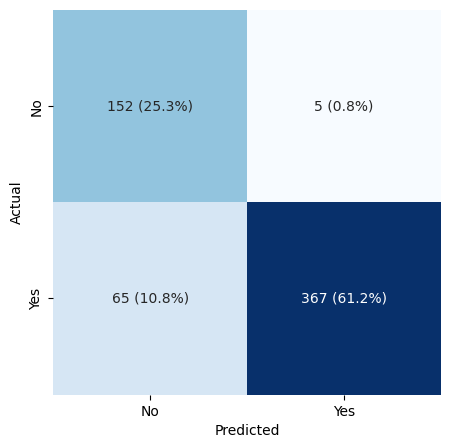

In [18]:
# Create confusion matrix of predicted and actual values for LOCAL
fig = plt.figure(figsize=(5, 5))

# Create labels with counts and percentages
labels_o1_local = cm_o1_local.values.astype(str)
labels_o1_local[0, 0] = f"{cm_o1_local.values[0,0]} ({100 * tn_o1_local/df.shape[0]:.1f}%)"
labels_o1_local[0, 1] = f"{cm_o1_local.values[0,1]} ({100 * fp_o1_local/df.shape[0]:.1f}%)"
labels_o1_local[1, 0] = f"{cm_o1_local.values[1,0]} ({100 * fn_o1_local/df.shape[0]:.1f}%)"
labels_o1_local[1, 1] = f"{cm_o1_local.values[1,1]} ({100 * tp_o1_local/df.shape[0]:.1f}%)"

sns.heatmap(cm_o1_local, annot=labels_o1_local, fmt="", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/o1_local_confusion.png", dpi=300, bbox_inches="tight")

In [19]:
# Create confusion matrix of predicted and actual values for METASTATIC
cm_o1_metastatic = pd.crosstab(df["ground_truth_metastatic"], df["o1_metastatic"])

# Calculate true positives, false positives, false negatives, and true negatives
tp_o1_metastatic = cm_o1_metastatic.loc[True, True]
fp_o1_metastatic = cm_o1_metastatic.loc[False, True]
fn_o1_metastatic = cm_o1_metastatic.loc[True, False]
tn_o1_metastatic = cm_o1_metastatic.loc[False, False]

# Calculate accuracy, precision, recall, f1 score
accuracy_o1_metastatic = (tp_o1_metastatic + tn_o1_metastatic) / (
    tp_o1_metastatic + tn_o1_metastatic + fp_o1_metastatic + fn_o1_metastatic
)
precision_o1_metastatic = tp_o1_metastatic / (tp_o1_metastatic + fp_o1_metastatic)
recall_o1_metastatic = tp_o1_metastatic / (tp_o1_metastatic + fn_o1_metastatic)
f1_score_o1_metastatic = (
    2
    * precision_o1_metastatic
    * recall_o1_metastatic
    / (precision_o1_metastatic + recall_o1_metastatic)
)

# Calculate the 95% confidence interval for the accuracy, precision, recall, and f1 score
accuracy_o1_metastatic_ci = 1.96 * np.sqrt((accuracy_o1_metastatic * (1 - accuracy_o1_metastatic)) / df.shape[0])
precision_o1_metastatic_ci = 1.96 * np.sqrt((precision_o1_metastatic * (1 - precision_o1_metastatic)) / df.shape[0])
recall_o1_metastatic_ci = 1.96 * np.sqrt((recall_o1_metastatic * (1 - recall_o1_metastatic)) / df.shape[0])
f1_score_o1_metastatic_ci = 1.96 * np.sqrt((f1_score_o1_metastatic * (1 - f1_score_o1_metastatic)) / df.shape[0])

print(f"Accuracy: {accuracy_o1_metastatic:.2f} ({accuracy_o1_metastatic-accuracy_o1_metastatic_ci:.2f} - {accuracy_o1_metastatic+accuracy_o1_metastatic_ci:.2f})")
print(f"Precision: {precision_o1_metastatic:.2f} ({precision_o1_metastatic-precision_o1_metastatic_ci:.2f} - {precision_o1_metastatic+precision_o1_metastatic_ci:.2f})")
print(f"Recall: {recall_o1_metastatic:.2f} ({recall_o1_metastatic-recall_o1_metastatic_ci:.2f} - {recall_o1_metastatic+recall_o1_metastatic_ci:.2f})")
print(f"F1 score: {f1_score_o1_metastatic:.2f} ({f1_score_o1_metastatic-f1_score_o1_metastatic_ci:.2f} - {f1_score_o1_metastatic+f1_score_o1_metastatic_ci:.2f})")

Accuracy: 0.99 (0.98 - 1.00)
Precision: 0.99 (0.98 - 1.00)
Recall: 0.99 (0.99 - 1.00)
F1 score: 0.99 (0.99 - 1.00)


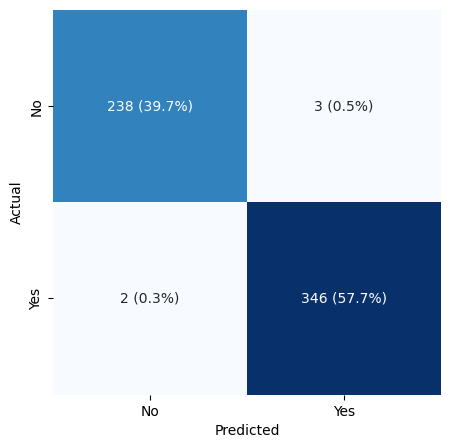

In [20]:
# Create confusion matrix of predicted and actual values for METASTATIC
fig = plt.figure(figsize=(5, 5))

# Create labels with counts and percentages
labels_o1_metastatic = cm_o1_metastatic.values.astype(str)
labels_o1_metastatic[0, 0] = f"{cm_o1_metastatic.values[0,0]} ({100 * tn_o1_metastatic/df.shape[0]:.1f}%)"
labels_o1_metastatic[0, 1] = f"{cm_o1_metastatic.values[0,1]} ({100 * fp_o1_metastatic/df.shape[0]:.1f}%)"
labels_o1_metastatic[1, 0] = f"{cm_o1_metastatic.values[1,0]} ({100 * fn_o1_metastatic/df.shape[0]:.1f}%)"
labels_o1_metastatic[1, 1] = f"{cm_o1_metastatic.values[1,1]} ({100 * tp_o1_metastatic/df.shape[0]:.1f}%)"

sns.heatmap(cm_o1_metastatic, annot=labels_o1_metastatic, fmt="", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("plots/o1_metastatic_confusion.png", dpi=300, bbox_inches="tight")

In [21]:
# Calculate the F1 score for local per family
precision_o1_local_per_family = df.groupby("family").apply(lambda x: np.sum((x["o1_local"] == True) & (x["ground_truth_local"] == True))/ np.sum(x["o1_local"] == True))
recall_o1_local_per_family = df.groupby("family").apply(lambda x: np.sum((x["o1_local"] == True) & (x["ground_truth_local"] == True))/ np.sum(x["ground_truth_local"] == True))
f1_score_o1_local_per_family = 2 * precision_o1_local_per_family * recall_o1_local_per_family / (precision_o1_local_per_family + recall_o1_local_per_family)
f1_score_o1_local_per_family = f1_score_o1_local_per_family.round(2)

print(f1_score_o1_local_per_family)

family
All                     0.88
Breast/Gynecological    0.95
Gastrointestinal        0.85
Head & neck             0.90
Lung/Thoracic           0.79
Neuro                   0.89
Skin/Soft tissue        0.94
Urogenital              0.95
dtype: float64


In [22]:
# Calculate the F1 score for metastatic per family
precision_o1_metastatic_per_family = df.groupby("family").apply(lambda x: np.sum((x["o1_metastatic"] == True) & (x["ground_truth_metastatic"] == True))/ np.sum(x["o1_metastatic"] == True))
recall_o1_metastatic_per_family = df.groupby("family").apply(lambda x: np.sum((x["o1_metastatic"] == True) & (x["ground_truth_metastatic"] == True))/ np.sum(x["ground_truth_metastatic"] == True))
f1_score_o1_metastatic_per_family = 2 * precision_o1_metastatic_per_family * recall_o1_metastatic_per_family / (precision_o1_metastatic_per_family + recall_o1_metastatic_per_family)
f1_score_o1_metastatic_per_family = f1_score_o1_metastatic_per_family.round(2)

print(f1_score_o1_metastatic_per_family)

family
All                     1.00
Breast/Gynecological    0.98
Gastrointestinal        0.98
Head & neck             0.92
Lung/Thoracic           0.99
Neuro                   0.91
Skin/Soft tissue        1.00
Urogenital              0.99
dtype: float64


## Analyse incorrect predictions by o1

In [23]:
# Create a dataframe of false positives for o1 local
df_fp_o1_local = df[(df["o1_local"] == True) & (df["ground_truth_local"] == False)]

# Create a dataframe of false negatives for o1 local
df_fn_o1_local = df[(df["o1_local"] == False) & (df["ground_truth_local"] == True)]

# Create a dataframe of false positives for o1 metastatic
df_fp_o1_metastatic = df[(df["o1_metastatic"] == True) & (df["ground_truth_metastatic"] == False)]

# Create a dataframe of false negatives for o1 metastatic
df_fn_o1_metastatic = df[(df["o1_metastatic"] == False) & (df["ground_truth_metastatic"] == True)]

### False negatives local

In [24]:
# Check how many of the false negative local predictions contain the string "recurrent"
print(f"False negatives that contain the string 'recurrent' in their abstract: {df_fn_o1_local[df_fn_o1_local['abstract'].str.contains('recurrent')].shape[0]}")
print(f"Percentage of false negatives that contain the string 'recurrent' in their abstract: {100 * df_fn_o1_local[df_fn_o1_local['abstract'].str.contains('recurrent')].shape[0] / df_fn_o1_local.shape[0]:.1f}%")


# Check how many of the false negative local predictions contain the string "advanced" in their abstract
print(
    f"False negatives that contain the string 'advanced' in their abstract: {df_fn_o1_local[df_fn_o1_local['abstract'].str.contains('advanced')].shape[0]}"
)
print(
    f"Percentage of false negatives that contain the string 'advanced' in their abstract: {100 * df_fn_o1_local[df_fn_o1_local['abstract'].str.contains('advanced')].shape[0] / df_fn_o1_local.shape[0]:.1f}%"
)

# Check how many of the false negative local predictions contain the string "locally advanced"
print(
    f"False negatives that contain the string 'locally advanced' in their abstract: {df_fn_o1_local[df_fn_o1_local['abstract'].str.contains('locally advanced')].shape[0]}"
)
print(
    f"Percentage of false negatives that contain the string 'locally advanced' in their abstract: {100 * df_fn_o1_local[df_fn_o1_local['abstract'].str.contains('locally advanced')].shape[0] / df_fn_o1_local.shape[0]:.1f}%"
)

False negatives that contain the string 'recurrent' in their abstract: 17
Percentage of false negatives that contain the string 'recurrent' in their abstract: 26.2%
False negatives that contain the string 'advanced' in their abstract: 39
Percentage of false negatives that contain the string 'advanced' in their abstract: 60.0%
False negatives that contain the string 'locally advanced' in their abstract: 0
Percentage of false negatives that contain the string 'locally advanced' in their abstract: 0.0%


### False negatives local

In [25]:
# Print the dois of the false negatives local
print(df_fn_o1_local["doi"].tolist())

['10.1200/JCO.20.02755', '10.1056/NEJMoa2112187', '10.1016/S1470-2045(10)70112-1', '10.1056/NEJMoa0810699', '10.1056/NEJMoa1611310', '10.1200/JCO.2010.28.0982', '10.1016/S1470-2045(12)70490-4', '10.1056/NEJMoa1910231', '10.1200/JCO.2006.06.0483', '10.1016/S1470-2045(11)70102-4', '10.1200/JCO.22.00332', '10.1016/S1470-2045(22)00603-9', '10.1056/NEJMoa1801946', '10.1200/JCO.2008.17.0530', '10.1200/JCO.2014.55.5789', '10.1016/S1470-2045(16)00106-6', '10.1016/S1470-2045(13)70067-6', '10.1016/S1470-2045(08)70261-4', '10.1200/JCO.2007.13.0856', '10.1200/JCO.2012.46.1764', '10.1200/JCO.2011.36.1709', '10.1056/NEJMoa1713137', '10.1200/JCO.2010.34.3178', '10.1016/S1470-2045(20)30493-9', '10.1200/JCO.23.00971', '10.1200/JCO.2004.10.020', '10.1200/JCO.2009.26.6452', '10.1001/jamaoncol.2022.5999', '10.1200/JCO.2005.03.616', '10.1200/JCO.2008.17.3138', '10.1016/S1470-2045(18)30372-3', '10.1016/S0140-6736(15)01283-0', '10.1200/JCO.2007.12.2614', '10.1200/JCO.2012.45.0494', '10.1200/JCO.2013.53.7746'

### False positives local


In [26]:
# Print the dois of the false positives local
print(df_fp_o1_local["doi"].tolist())

['10.1056/NEJMoa1506197', '10.1016/S0140-6736(10)60551-X', '10.1016/S0140-6736(12)62186-2', '10.1056/NEJMoa050493', '10.1001/jama.2019.4755']


### False negatives metastatic

In [27]:
# Print the dois of the false negatives metastatic
print(df_fn_o1_metastatic["doi"].tolist())

['10.1200/JCO.2005.09.102', '10.1200/JCO.2005.09.050']


### False positives metastatic

In [28]:
# Print the dois of the false positives metastatic
print(df_fp_o1_metastatic["doi"].tolist())


['10.1200/JCO.2006.06.6027', '10.1200/JCO.2009.23.5150', '10.1200/JCO.21.00703']


In [30]:
# Create a new csv that contains only the columns doi and accept
df_accepted = df[["doi", "accept"]]

# Rename the column accept to accept_new
df_accepted = df_accepted.rename(columns={"accept": "accept_new"})

# Save the dataframe to a csv file
df_accepted.to_csv("accepted_new.csv", index=False)